## Deep Fake Detection Challenge

### Data Processing

##### Imports

In [1]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
import cv2
from typing import Tuple
from model2D import *
from model3D import *

2023-04-12 12:07:12.920107: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-12 12:07:13.125883: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-12 12:07:13.127587: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-12 12:07:14.631542: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


##### Data Description

In [2]:
train_videoes = "data/train_sample_videos"
test_videos = "data/test_videos"

print(f"Train Videoes: {len(os.listdir(train_videoes))}\nTest Vidoes: {len(os.listdir(test_videos))}")

Train Videoes: 402
Test Vidoes: 163


In [3]:
meta_data = pd.read_json(train_videoes+"/metadata.json").T
meta_data.head()
labels_col =meta_data["label"].to_list()
paths_col = meta_data.index.to_list()
paths_col

['aagfhgtpmv.mp4',
 'aapnvogymq.mp4',
 'abarnvbtwb.mp4',
 'abofeumbvv.mp4',
 'abqwwspghj.mp4',
 'acifjvzvpm.mp4',
 'acqfdwsrhi.mp4',
 'acxnxvbsxk.mp4',
 'acxwigylke.mp4',
 'aczrgyricp.mp4',
 'adhsbajydo.mp4',
 'adohikbdaz.mp4',
 'adylbeequz.mp4',
 'aelfnikyqj.mp4',
 'aelzhcnwgf.mp4',
 'aettqgevhz.mp4',
 'aevrfsexku.mp4',
 'afoovlsmtx.mp4',
 'agdkmztvby.mp4',
 'agqphdxmwt.mp4',
 'agrmhtjdlk.mp4',
 'ahbweevwpv.mp4',
 'ahdbuwqxit.mp4',
 'ahfazfbntc.mp4',
 'ahqqqilsxt.mp4',
 'aipfdnwpoo.mp4',
 'ajqslcypsw.mp4',
 'ajwpjhrbcv.mp4',
 'aklqzsddfl.mp4',
 'aknbdpmgua.mp4',
 'aknmpoonls.mp4',
 'akvmwkdyuv.mp4',
 'akxoopqjqz.mp4',
 'akzbnazxtz.mp4',
 'aladcziidp.mp4',
 'alaijyygdv.mp4',
 'alninxcyhg.mp4',
 'altziddtxi.mp4',
 'alvgwypubw.mp4',
 'amaivqofda.mp4',
 'amowujxmzc.mp4',
 'andaxzscny.mp4',
 'aneclqfpbt.mp4',
 'anpuvshzoo.mp4',
 'aorjvbyxhw.mp4',
 'apatcsqejh.mp4',
 'apgjqzkoma.mp4',
 'apogckdfrz.mp4',
 'aqpnvjhuzw.mp4',
 'arkroixhey.mp4',
 'arlmiizoob.mp4',
 'arrhsnjqku.mp4',
 'asaxgevnnp

In [4]:
def visualize_real_vs_fake(class_count: list) -> None:
    plt.pie(class_count, labels=["Real Videos", "Deep Fake Videos"], autopct='%.2f%%',
       wedgeprops={'linewidth': 2.5, 'edgecolor': 'white'},
       textprops={'size': 'large', 'fontweight': 'bold'})
    plt.title("Proportion of Real vs Deep Fake videos in the training dataset.", fontdict={'fontweight': 'bold'})
    plt.legend([f"Real Videos Count: {class_count[0]}", f"Deep Fake Videos Count: {class_count[1]}"], bbox_to_anchor=(0.5, 0.05), bbox_transform=plt.gcf().transFigure, loc="lower center", prop={'weight':'bold'})
    plt.savefig("images/pie_chart_class_proportions.jpg")
    plt.show()

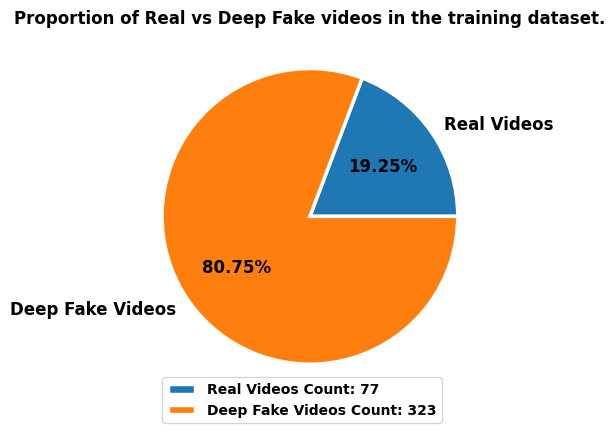

In [5]:
label_count_series = meta_data["label"].value_counts()
fake_count = label_count_series["FAKE"]
real_count = label_count_series["REAL"]

visualize_real_vs_fake([real_count, fake_count])

Quite skewed dataset. Might want to consider upsampling of real classes

In [17]:
def get_frames_v1(paths: list, frames_each_video: int, video_amount: int) -> list:
    video_array = []
    
    for idx, path in enumerate(paths): # bedre me enumerate her?
        if idx == video_amount:
            break
        vc = cv2.VideoCapture(path)
        frames_to_skip = (int(vc.get(cv2.CAP_PROP_FRAME_COUNT))-1)/frames_each_video
        frames_to_skip=round(frames_to_skip)
        """ print(int(vc.get(cv2.CAP_PROP_FRAME_COUNT)))
        if(int(vc.get(cv2.CAP_PROP_FRAME_COUNT))!=300):
            print(path)
            print(int(vc.get(cv2.CAP_PROP_FRAME_COUNT))) """
        video = []
        i = 0
        while vc.isOpened():
            i += 1
            ret, frame = vc.read()
            if ret and frame is not None:
                if i % frames_to_skip != 0:
                    continue
                if frame.shape[0] == 1920:
                    frame = frame.transpose(1, 0, 2)
                frame = cv2.resize(frame, (1280, 720))
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                video.append(frame)
            else:
                vc.release()
                break
        video_array.append(np.array(video))  
    return np.array(video_array)

training_videos_sample = os.listdir(train_videoes)
sample_file_names = training_videos_sample.copy()
complete_paths = []
for i in range(len(training_videos_sample)):
    if training_videos_sample[i].endswith('mp4'):
        complete_paths.append(train_videoes+"/"+training_videos_sample[i])
complete_paths.sort()
video_array = get_frames_v1(paths=complete_paths, frames_each_video=5, video_amount=2)


60
120
180
240
300
60
120
180
240
300
60
120
180
240
300
60
120
180
240
300
60
120
180
240
300
60
120
180
240
300
60
120
180
240
300
60
120
180
240
300
59
118
177
236
295
60
120
180
240
300


In [7]:
print(video_array[7])
print(video_array[8])

[[[[154 156 156]
   [154 156 156]
   [154 156 156]
   ...
   [142 140 136]
   [143 141 137]
   [144 142 138]]

  [[154 156 156]
   [154 156 156]
   [154 156 156]
   ...
   [141 139 135]
   [143 141 137]
   [143 141 137]]

  [[154 156 156]
   [154 156 156]
   [154 156 156]
   ...
   [143 141 137]
   [143 141 137]
   [144 142 138]]

  ...

  [[ 37  37  34]
   [ 39  39  36]
   [ 43  43  40]
   ...
   [126 134 143]
   [126 134 143]
   [126 134 143]]

  [[ 37  37  34]
   [ 40  40  37]
   [ 44  44  41]
   ...
   [126 134 143]
   [126 134 143]
   [126 134 143]]

  [[ 38  38  35]
   [ 42  42  39]
   [ 45  45  42]
   ...
   [126 134 143]
   [126 134 143]
   [126 134 143]]]


 [[[152 154 154]
   [152 154 154]
   [152 154 154]
   ...
   [140 143 135]
   [140 143 135]
   [138 141 133]]

  [[152 154 154]
   [152 154 154]
   [152 154 154]
   ...
   [140 143 135]
   [140 143 135]
   [138 141 133]]

  [[154 156 156]
   [154 156 156]
   [154 156 156]
   ...
   [140 143 135]
   [140 143 135]
   [138 141

In [18]:
print(video_array.shape)

(10, 5, 720, 1280, 3)


In [9]:
labels_col.pop(8)
y = [0 if val!="FAKE" else 1 for val in labels_col ]
y =np.array(y)


In [10]:
print(f"Amount of Videos: {len(video_array)}")
print(f"Frames for videos: {[len(video_array[i]) for i in range(len(video_array))]}")

Amount of Videos: 10
Frames for videos: [5, 5, 5, 5, 5, 5, 5, 5, 4, 5]


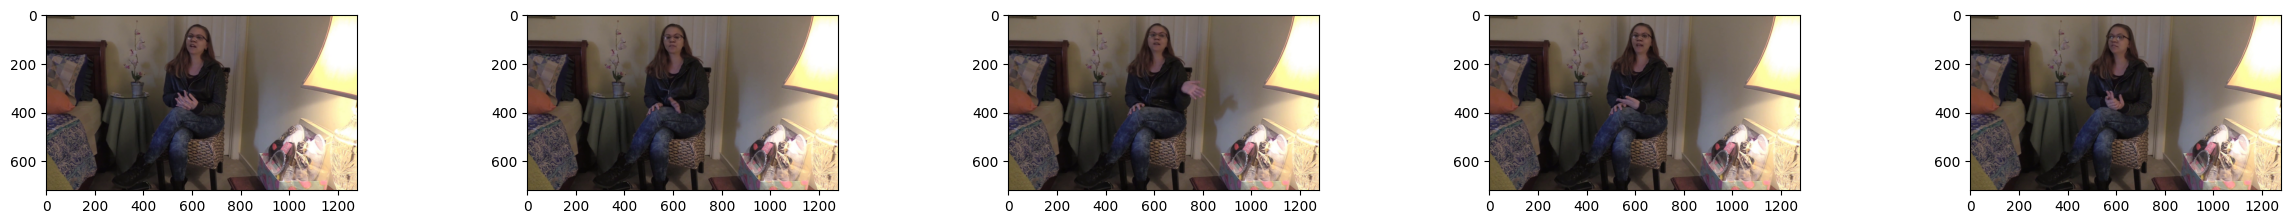

In [11]:
def plot_video(video: list, figsize: tuple, width: int, height: int) -> None:
    fig = plt.figure(figsize=figsize)
    for i in range(len(video[:(width*height)])):
        plt.subplot(width, height, i+1)
        plt.imshow(video[i])
    plt.show()

plot_video(video_array[6], (30,5), 2, 5)

In [12]:
from sklearn.manifold import TSNE
frames_list = video_array[0]
frames_array = np.array([frame.flatten() for frame in frames_list])
# Instantiate t-SNE object with desired parameters
print(2)
tsne = TSNE(n_components=2, perplexity=10, random_state=0)

# Fit t-SNE on the frames array
frames_tsne = tsne.fit_transform(frames_array)

2


ValueError: perplexity must be less than n_samples

In [ ]:
# Assuming labels is a list of labels corresponding to each frame
plt.scatter(frames_tsne[:,0], frames_tsne[:,1], c=range(0,20))
plt.show()

NameError: name 'frames_tsne' is not defined

In [ ]:
def format_frames(vid_arr):
    flatten_first_video_frame = vid_arr[0][0]
    flatten_first_video_frame = flatten_first_video_frame / 255
    return np.array([flatten_first_video_frame])
first_frame_formatted = format_frames(video_array)
first_frame_formatted.shape

(1, 720, 1280, 3)

### BUILD MODEL
- Add Layers
- Add Loss function, optimizers, and metrics
- Compile model and Fit

In [ ]:
model_2D = build_2D_model(first_frame_formatted)
model_2D.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 720, 1280, 32)     4736      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 240, 426, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 240, 426, 3)       867       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 80, 142, 3)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 80, 142, 3)        84        
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 47, 3)        0

2023-04-11 16:17:02.532736: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Total params: 475,321
Trainable params: 475,321
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_2D = compile_2D_model(model_2D, 0.001)

In [ ]:
video_array.shape

(20, 0)

In [ ]:
model_3D = build_3D_model(video_array)
model_3D.summary()

2023-04-11 16:55:17.924542: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 5, 720, 1280, 32)  2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 3, 360, 640, 32)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 3, 360, 640, 3)    2595      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 2, 180, 320, 3)   0         
 3D)                                                             
                                                                 
 conv3d_2 (Conv3D)           (None, 2, 180, 320, 3)    246       
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 1, 90, 160, 3)    0

In [ ]:
#model_3D = build_3D_model(video_array)
model_3D.fit(video_array,y[:video_array.shape[0]],epochs=5,steps_per_epoch=2,batch_size=5)

Epoch 1/5
2/2 [==============================] - 298s 148s/step - loss: 5.9945 - accuracy: 0.9000
Epoch 2/5
2/2 [==============================] - 279s 138s/step - loss: 3.6378 - accuracy: 0.4000
Epoch 3/5
2/2 [==============================] - 377s 184s/step - loss: 0.6645 - accuracy: 0.3000
Epoch 4/5
2/2 [==============================] - 282s 144s/step - loss: 0.9475 - accuracy: 0.2000
Epoch 5/5
2/2 [==============================] - 264s 133s/step - loss: 0.7340 - accuracy: 0.1000


In [ ]:
loss = keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
metrics=["accuracy"]
model_3D.compile(optimizer=optimizer, loss=loss, metrics=metrics)